# Today.txt

In [40]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def f(big_goal, one, two, three):
    output = "If nothing else, today I am going to " + big_goal + ".\n"
    output += "I am going to do this by " + one + " then " + two + " then " + three + ".\n"
    output += "If I do this and only this, [" + datetime.datetime.today().strftime('%d.%m.%Y')
    output += " will be a good day](http://johnhenrymuller.com/today)."

    fo = open("today.txt", "w")
    fo.write(output)
    fo.close()
    s()

def s():
    today = open("today.txt", 'r').read()
    lines = today.split("\n")
    big_goal = lines[0][len("If nothing else, today I am going to "):-1]
    parts = [p.strip() for p in lines[1][len("I am going to do this by "):-1].split("then")]
    print(big_goal)
    print(parts)

s()
interact(f, big_goal=big_goal, one=parts[0], two=parts[1], three=parts[2], __manual=True)
    


Whateversdfasd
['A asdfasdf', 'Bfsdfsad asdfasd', 'Cdfasdf']


# Get Outstanding Tasks

In [41]:
not_showing = 0

output = open("header.html", 'r').read()
output += markdown(open("today.txt", 'r').read())

total = 0
shown = 0

for course in Course.list_all("courses"):
    step = course.current_step()
    total += 1
    if step == None:
        continue
    ping_radius = int(course.ping_radius())
    if ping_radius > 3:
        continue
    shown += 1    

    title = course.course_desc.title  + " (" + str(ping_radius) + " days)"
    if Meta.URL in course.course_desc.meta:
        title = "## [" + title + "](" + course.course_desc.meta[Meta.URL] + ")"
    else:
        title = "## " + title + ""

    if Meta.THUMB in course.course_desc.meta:
        output += get_img(course.course_desc.meta[Meta.THUMB])
        
    display(HTML(markdown(title)))
    output += markdown(title)
    
    print(course.fullpath)
    
    if Meta.LEARNING_GOAL in step.meta:
        display(HTML(markdown("_" + Meta.LEARNING_GOAL + "_: " + step.meta[Meta.LEARNING_GOAL])))
        output += markdown("\n\n_" + Meta.LEARNING_GOAL + "_: " + step.meta[Meta.LEARNING_GOAL])
    
    display(HTML(markdown("* " + "\n* ".join(step.tasks))))
    output += markdown("\n\n* " + "\n* ".join(step.tasks))
    
display(HTML("<h2><em>Shown: " + str(shown) + "/" + str(total) + " </em></h2>"))
output += "\n<h2><em>Shown: " + str(shown) + "/" + str(total) + " </em></h2>\n"


fo = open("index.html", "w")

fo.write(output)

fo.close()


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\art-of-programming\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\character-design\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\current-big-sci\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\german\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\graphic-design\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\music-theory\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\script-writing\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\songwriting\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\stats\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\the-blues\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\yoga\README.md


In [16]:
def get_img(imgsrc):
    return '''<p><label for="mn-figure-1" class="margin-toggle">&#8853;</label>
            <input type="checkbox" id="mn-figure-1" class="margin-toggle"/><span class="marginnote">
           <img src="images/''' + imgsrc + '''"></p>'''

# Identify missing metadata

C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\ancient-philosophy\README.md lacks Category
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\ancient-philosophy\README.md lacks Start
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\art-of-programming\README.md = Readings 0
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\art-of-programming\README.md lacks Start
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\big-history\README.md = History 0
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\buddhism-psych\README.md lacks Category
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\character-design\README.md lacks Category
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\chinese-classics\README.md = Philosophy 0
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\chinese-classics\README.md lacks Start
C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\classical-sociology\README.md lacks Category
C:\Users\Kateryna.Kuksenok\Doc

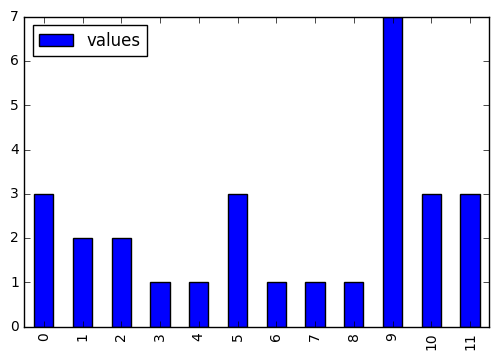

In [10]:
data = {}

for course in Course.list_all("courses"):
    if Meta.CATEGORY not in course.course_desc.meta:
        print(course.fullpath + " lacks " + Meta.CATEGORY)
    else:
        data[course.course_desc.meta[Meta.CATEGORY]] = data.get(course.course_desc.meta[Meta.CATEGORY], 0) + 1
        print(course.fullpath + " = " + course.course_desc.meta[Meta.CATEGORY], 0)
    if Meta.START not in course.course_desc.meta:
        print(course.fullpath + " lacks " + Meta.START)

cats = data.keys()
vals = []
for i, cat in enumerate(cats):
    print(str(i) + " " + cat)
    vals.append(data[cat])

df = pd.DataFrame({"categories": cats, "values": vals})
df.plot(kind = "bar")
plt.show()

# Celebrate Accomplishments

C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\big-history\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\character-design\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\classical-sociology\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\conlanging\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\learning\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\meta\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\music-tech\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\music-theory\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\questionnaire-design\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\script-writing\README.md


C:\Users\Kateryna.Kuksenok\Documents\headhunger\courses\stats\README.md


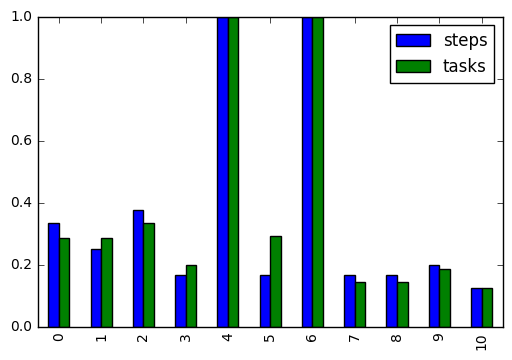

0 = Big History: Connecting Knowledge
1 = Video Game Character Design
2 = Classical Sociology Theory
3 = Language Invention
4 = Learning How to Learn
5 = Meta: Design and Develop Self-Guided Learning Dashboard
6 = Survey of Music Technology
7 = Fundamentals of Music Theory
8 = Questionnaire Design for Social Surveys
9 = Script Writing
10 = Improving your statistical inferences


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = {"courses": [], "steps":[], "tasks":[]}

for course in Course.list_all("courses"):
    steps_completed = 0
    steps_total = 0
    tasks_completed = 0
    tasks_total = 0
    for step in course.steps:
        if len(step.finished) + len(step.tasks) > 0:
            steps_total += 1
            if len(step.tasks) == 0:
                steps_completed += 1
            tasks_completed += len(step.finished)
            tasks_total += len(step.finished) + len(step.tasks)

    if steps_completed == 0 and Meta.END not in course.course_desc.meta:
        continue
    
    data["courses"].append(course.course_desc.title)
    if Meta.END in course.course_desc.meta:
        data["steps"].append(1)
        data["tasks"].append(1)
    else:
        data["steps"].append(steps_completed/steps_total)
        data["tasks"].append(tasks_completed/tasks_total)
    
    title = course.course_desc.title  + " (" + str(steps_completed) + "/" + str(steps_total) + " steps, " + str(tasks_completed) + "/" + str(tasks_total) + " tasks)"
    if Meta.URL in course.course_desc.meta:
        title = "[" + title + "](" + course.course_desc.meta[Meta.URL] + ")"
    
    display(HTML("<h2>" + markdown(title) + "</h2>"))
    print(course.fullpath)
    for step in course.steps:
        
        if len(step.finished) > 0:

            if Meta.LEARNING_GOAL in step.meta:
                display(HTML(markdown("_" + Meta.LEARNING_GOAL + "_: " + step.meta[Meta.LEARNING_GOAL])))
            if Meta.REFLECTION in step.meta:
                display(HTML(markdown("_" + Meta.REFLECTION + "_: " + step.meta[Meta.REFLECTION])))
            
            for f in step.finished:
                if len(f) > 50: # Another condition for being interesting would be having a URL or image
                    display(HTML(markdown("* " + f)))
            
df = pd.DataFrame(data)
df.plot(kind = "bar")
plt.show()
for i, c in enumerate(data["courses"]):
    print(str(i) + " = " + c)

# Showcase Project Portfolio

In [ ]:
# TODO :)
# This should generate a website

# Modify Parser and Data Structures

In [2]:
import os
import os.path
import time, datetime

from IPython.core.display import display, HTML
import mistune

markdown = mistune.Markdown()

class CourseFSM:
    
    READING_PORTFOLIO = 1
    READING_STEPS = 2
    COURSE_DESC = 3
    COURSE_TITLE = 0
    
    def __init__(self):
        self.state = CourseFSM.COURSE_TITLE
    
    def update(self, line, course_desc, portfolio, steps):
        if line.startswith("#"):
            title = line.split(" ", 1)[1].strip()
            if self.state == CourseFSM.COURSE_TITLE:
                course_desc.title = title
                self.state = CourseFSM.COURSE_DESC
            elif title == Meta.PORTFOLIO:
                portfolio.append(MetaBlock())
                self.state = CourseFSM.READING_PORTFOLIO
            elif title.startswith(Meta.NUMBERED_STEP):
                steps.append(MetaBlock(title))
                self.state = CourseFSM.READING_STEPS
        elif self.state == CourseFSM.READING_PORTFOLIO or self.state == CourseFSM.READING_STEPS:
            if len(line.strip()) == 0:
                if self.state == CourseFSM.READING_PORTFOLIO:
                    portfolio.append(MetaBlock())
            else:
                if self.state == CourseFSM.READING_PORTFOLIO:
                    portfolio[-1].add_meta(line)
                else:
                    steps[-1].add_meta(line)
        elif self.state == CourseFSM.COURSE_DESC:
            course_desc.add_meta(line)
        
class Course:
    
    def list_all(coursepath):
        out = []
        for shortpath in os.listdir(coursepath):
            fullpath = os.path.join(coursepath, shortpath)
            if os.path.isdir(fullpath) and not shortpath.startswith("_"):
                out.append(Course(os.path.join(fullpath,"README.md")))
        return out
    
    def day_diff(dmy1, dmy2):
        dmy1 = Course.to_epoch(dmy1)
        dmy2 = Course.to_epoch(dmy2)
        return (dmy1-dmy2)/60/60/24
        
    def to_epoch(strtime, default = None):
        dt = datetime.datetime.strptime(strtime, "%d.%m.%Y")
        return time.mktime(dt.timetuple())
    
    def ping_radius(self):
        if not Meta.PING in self.course_desc.meta:
            return 0
        return Course.day_diff(self.course_desc.meta[Meta.PING],datetime.datetime.today().strftime('%d.%m.%Y'))
    
    def current_step(self):
        for step in self.steps:
            if len(step.tasks) > 0:
                return step
    
    def __init__(self, fullpath):
        #print("reading " + fullpath)
        s = open(fullpath, 'r').read()
        self.fullpath = os.path.abspath(fullpath)
        self.course_desc = MetaBlock()
        self.portfolio = []
        self.steps = []
        
        state = CourseFSM()
        
        for line in s.split("\n"):
            state.update(line, self.course_desc, self.portfolio, self.steps)
    
    #TODO write self back out
        
    def __str__(self):
        return str(self.course_desc) + ":\n\t" + "\n\t".join((str(mb) for mb in self.steps))
    
class MetaBlock:
        
    def __init__(self, title = "?"):
        self.title = title
        self.meta = {}
        self.tasks = []
        self.finished = []
        
    def add_meta(self, line):
        if line.startswith(Meta.TODO):
            self.tasks.append(line[len(Meta.TODO):].strip())
            return True
        elif line.startswith(Meta.FINISHED):
            self.finished.append(line[len(Meta.FINISHED):].strip())
            return True
        
        line = line.split(Meta.SEPARATOR, 1)
        if len(line) < 2:
            return False
        if line[0] in Meta.SUPPORTED:
            self.meta[line[0]] = line[1].strip()
            return True
        print("Error: unrecognized meta header in " + str(line))
        return False
    
    def __str__(self):
        return self.title + " (" + str(len(self.finished)) + "/" + str(
            len(self.finished) + len(self.tasks)) + ")" + "\n\t\t" + "\n\t\t".join(
            (key + "=" + value for key,value in self.meta.items())) + "\n\t\t" + "\n\t\t".join(
            ("- [ ]" + t for t in self.tasks)) + "\n\t\t" + "\n\t\t".join(
            ("- [X]" + t for t in self.finished))
        
class Meta:
    SEPARATOR = ":"
    CASE_SENSITIVE = True
    CATEGORY = "Category"
    CURRICULUM = "Curriculum"
    PING = "Ping"
    URL = "URL"
    PHOTO_CREDIT = "Photo-Credit"
    THUMB = "Thumb"
    LEARNING_GOAL = "Learning Goal"
    REFLECTION = "Reflection"
    TITLE = "Title"
    DESCRIPTION = "Description"
    PROJECT = "Project"
    KEYWORDS = "Keywords"
    START = "Start"
    END = "End"
    TODO = "- [ ]"
    FINISHED = "- [X]"
    SUPPORTED = [URL, CATEGORY, CURRICULUM, PING, PHOTO_CREDIT, THUMB, LEARNING_GOAL,
                 REFLECTION, KEYWORDS, TITLE, DESCRIPTION, PROJECT, START, END]
    PORTFOLIO = "Portfolio"
    NUMBERED_STEP = "Week"